Processing contact files...
Found 11 significant residues to plot.


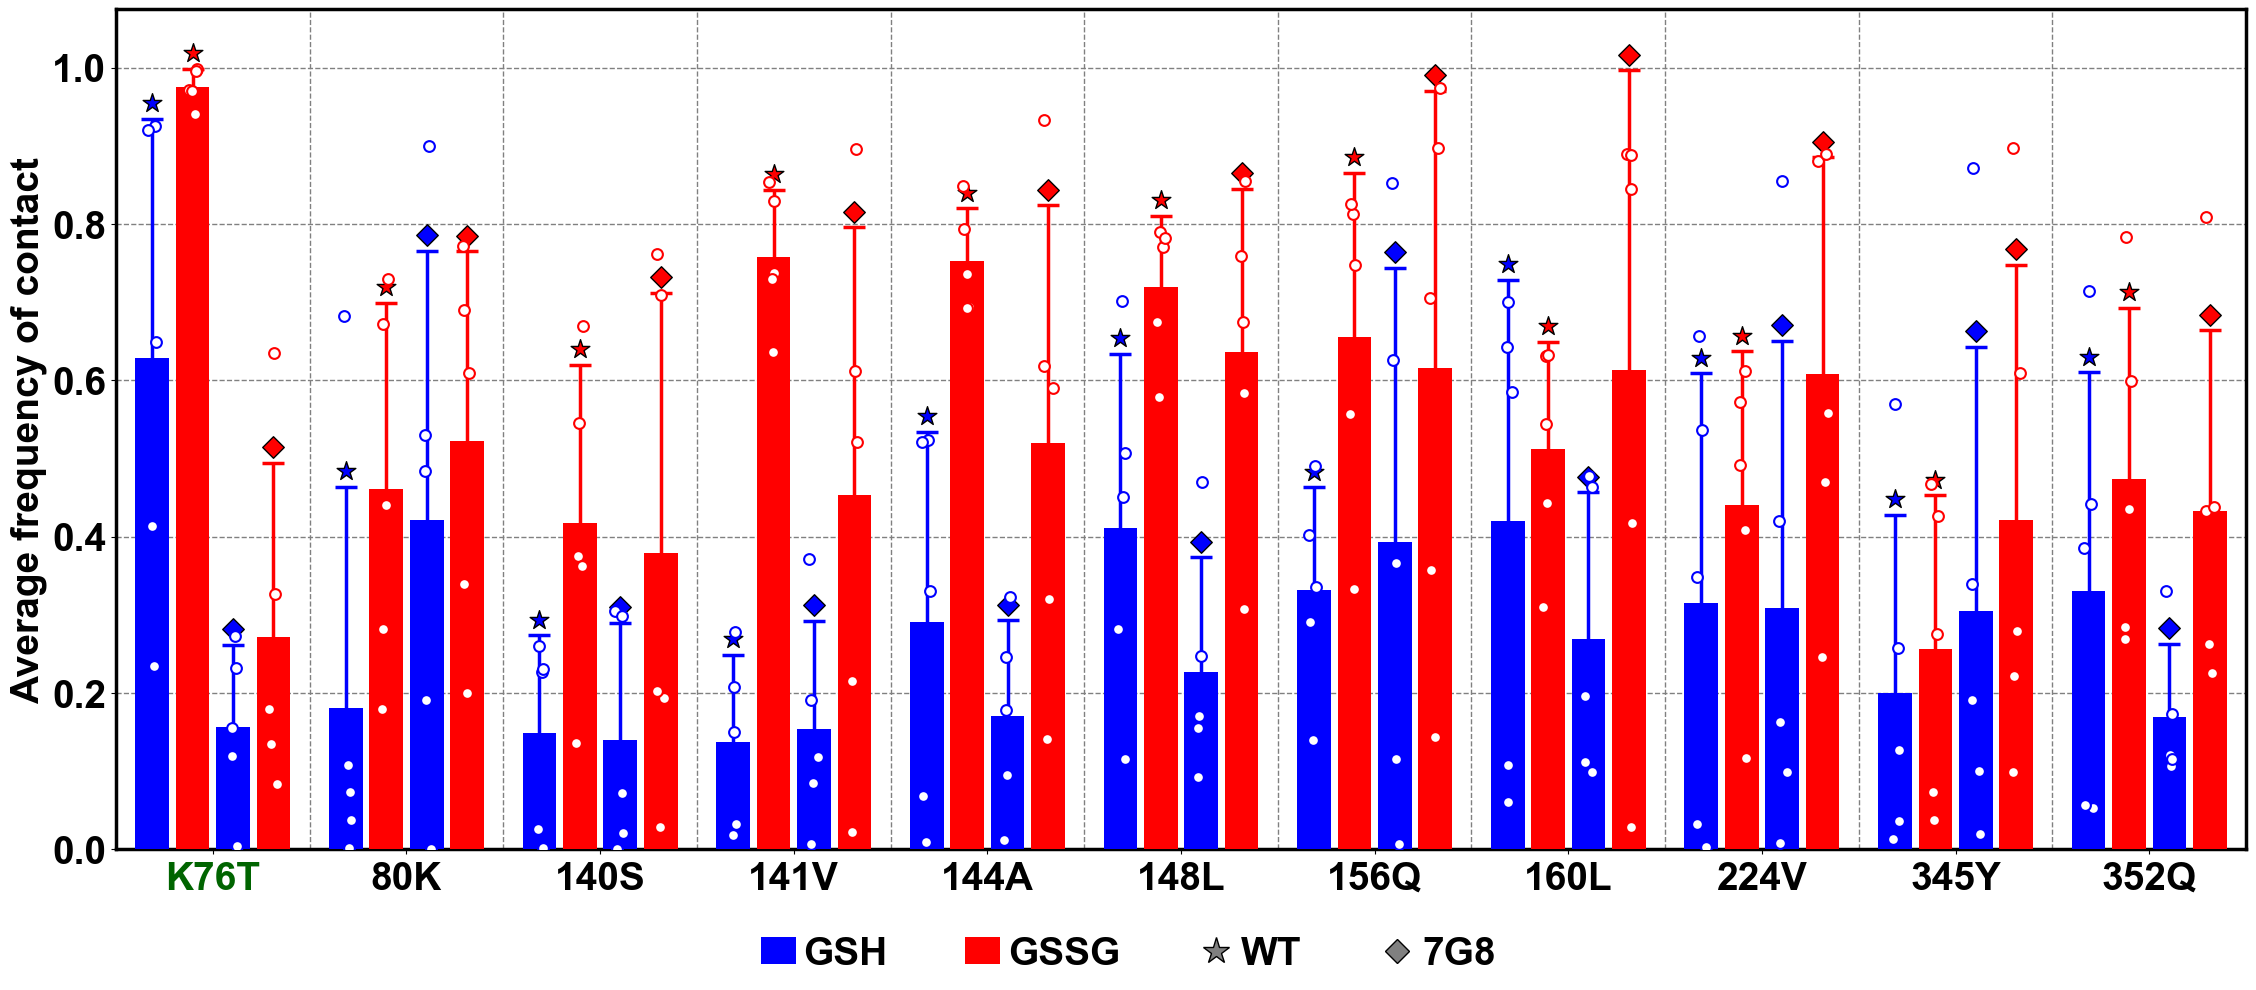


Saved figure to: z-figure-main-paper-19-Sep/z_avg_contacts_by_residue_0.4_no_CQ.png


In [46]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.close('all')
plt.rcdefaults()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

fontsize = 28
plt.rcParams['font.size'] = fontsize
spine_linewidth = 2.5

CONTACT_THRESHOLD = 0.4
OUTPUT_DIR = "z-figure-main-paper-19-Sep/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

THREE_TO_ONE = {
    'ALA':'A', 'CYS':'C', 'ASP':'D', 'GLU':'E', 'PHE':'F', 'GLY':'G',
    'HIS':'H', 'HSP':'H', 'HSD':'H', 'HSE':'H', 'ILE':'I', 'LYS':'K',
    'LEU':'L', 'MET':'M', 'ASN':'N', 'PRO':'P', 'GLN':'Q', 'ARG':'R',
    'SER':'S', 'THR':'T', 'VAL':'V', 'TRP':'W', 'TYR':'Y'
}
MUTATED_RESIDUES = {76, 220, 271, 326, 356, 371}

CONDITION_COLORS = {
    'GSH': (0, 0, 1),
    'GSSG': (1, 0, 0),
}

all_paths_7g8 = glob.glob("PfCRT-docked-pose/rep*7g8*/z_result_tcl_protein_contacts.csv")
all_paths_hb3 = glob.glob("PfCRT-docked-pose-hb3/rep*/z_result_tcl_protein_contacts.csv")
paths = all_paths_7g8 + all_paths_hb3

total_frames = 20000
all_contacts = []

print("Processing contact files...")
for p in sorted(paths):
    try:
        d = p.split(os.sep)[1]
        rep, grp, cond = d.split('-')[:3]
        if cond.lower() == 'cq':
            continue

        df = pd.read_csv(p)
        if df.empty:
            continue

        df['fraction'] = df['frames_in_contact'] / total_frames
        df['group'] = 'WT' if grp == 'hb3' else '7G8'
        df['condition'] = cond.upper().replace('GSD', 'GSSG')
        df['pose'] = int(rep.lstrip('rep'))
        df['resname_one'] = df['resname'].map(THREE_TO_ONE)

        all_contacts.append(df[['group', 'condition', 'pose', 'resid', 'resname_one', 'fraction']])
    except (ValueError, IndexError) as e:
        print(f"Could not parse file path: {p}. Error: {e}")
        continue

if not all_contacts:
    raise ValueError("No contact data found or processed. Please check file paths and formats.")

master_df = pd.concat(all_contacts, ignore_index=True)

avg_df = master_df.groupby(['group', 'condition', 'resid'])['fraction'].mean().reset_index()
significant_resids = sorted(avg_df[avg_df['fraction'] > CONTACT_THRESHOLD]['resid'].unique())
if len(significant_resids) == 0:
    raise ValueError(f"No residues found with an average contact fraction > {CONTACT_THRESHOLD}")

print(f"Found {len(significant_resids)} significant residues to plot.")

plot_df_full = master_df[master_df['resid'].isin(significant_resids)]
plot_agg = plot_df_full.groupby(['group', 'condition', 'resid', 'resname_one'])['fraction'].agg(['mean', 'std']).reset_index()
plot_agg['std'] = plot_agg['std'].fillna(0)

resname_lookup = plot_agg.pivot_table(index='resid', columns='group', values='resname_one', aggfunc='first')

xtick_labels = []
for resid in significant_resids:
    if resid in MUTATED_RESIDUES:
        wt_aa = resname_lookup.at[resid, 'WT']
        g8_aa = resname_lookup.at[resid, '7G8']
        label = f"{wt_aa}{resid}{g8_aa}"
    else:
        aa = resname_lookup.at[resid, 'WT']
        label = f"{resid}{aa}"
    xtick_labels.append(label)

fig, ax = plt.subplots(figsize=(len(xtick_labels) * 1.2 + 10, 12))

cluster_spacing = 1.15
x = np.arange(len(xtick_labels)) * cluster_spacing

width = 0.20

intracluster_spread = 1.20

base_offsets = {
    ('WT', 'GSH'):  -1.5,
    ('WT', 'GSSG'): -0.5,
    ('7G8','GSH'):   0.5,
    ('7G8','GSSG'):  1.5,
}
bar_positions = {k: v * width * intracluster_spread for k, v in base_offsets.items()}

rng = np.random.default_rng(42)

y_top_est = (plot_agg['mean'] + plot_agg['std']).max()
y_offset  = 0.02 * (y_top_est if y_top_est > 0 else 1.0)

for i, resid in enumerate(significant_resids):
    for group, cond in [('WT','GSH'), ('WT','GSSG'), ('7G8','GSH'), ('7G8','GSSG')]:
        subset = plot_agg[(plot_agg['group'] == group) &
                          (plot_agg['condition'] == cond) &
                          (plot_agg['resid'] == resid)]
        if subset.empty:
            continue

        mean_val = float(subset['mean'].values[0])
        std_val  = float(subset['std'].values[0])
        xpos     = x[i] + bar_positions[(group, cond)]

        ax.bar(
            xpos, mean_val, width,
            yerr=std_val if std_val > 0 else None,
            color=CONDITION_COLORS[cond],
            edgecolor='none',
            linewidth=0,
            error_kw={
                'ecolor': CONDITION_COLORS[cond],
                'elinewidth': 2.5,
                'capsize': 8,
                'capthick': 2.5
            },
            zorder=3
        )

        top_y = mean_val + std_val + y_offset
        marker = '*' if group == 'WT' else 'D'
        marker_size = 200 if marker == '*' else 120
        ax.scatter(
            [xpos], [top_y],
            marker=marker,
            s=marker_size,
            facecolors=CONDITION_COLORS[cond],
            edgecolors='black',
            linewidths=1.0,
            zorder=5
        )

        raw = plot_df_full[(plot_df_full['group'] == group) &
                           (plot_df_full['condition'] == cond) &
                           (plot_df_full['resid'] == resid)]
        if not raw.empty:
            vals = raw['fraction'].values
            jit = (rng.uniform(-0.25, 0.25, size=len(vals))) * (width * 0.6)
            ax.scatter(
                xpos + jit, vals,
                marker='o',
                s=60,
                facecolors='white',
                edgecolors=CONDITION_COLORS[cond],
                linewidths=1.5,
                zorder=6
            )

ax.set_ylabel('Average frequency of contact', fontsize=fontsize, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=0, fontsize=fontsize, fontweight='bold')
edge_pad = cluster_spacing / 2.0
ax.set_xlim(x[0] - edge_pad, x[-1] + edge_pad)

ax.tick_params(axis='x', which='major', pad=5)
ax.tick_params(axis='y', labelsize=fontsize)

for label in ax.get_yticklabels():
    label.set_fontweight('bold')

for i, label in enumerate(ax.get_xticklabels()):
    if significant_resids[i] in MUTATED_RESIDUES:
        label.set_color('darkgreen')

midpoints = (x[:-1] + x[1:]) / 2.0
for m in midpoints:
    ax.axvline(m, linestyle='--', linewidth=1, color='gray', zorder=0)

ax.yaxis.grid(True, linestyle='--', linewidth=1, color='gray', zorder=0)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(spine_linewidth)

cond_handles = [
    Patch(facecolor=CONDITION_COLORS['GSH'],  edgecolor='none', label='GSH'),
    Patch(facecolor=CONDITION_COLORS['GSSG'], edgecolor='none', label='GSSG'),
]
group_handles = [
    Line2D([], [], marker='*', linestyle='None', markersize=20,
           markerfacecolor='gray', markeredgecolor='black', label='WT'),
    Line2D([], [], marker='D', linestyle='None', markersize=12,
           markerfacecolor='gray', markeredgecolor='black', label='7G8'),
]

fig.legend(
    handles=cond_handles + group_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.125),
    ncol=4,
    frameon=False,
    prop={'size': fontsize, 'weight': 'bold'},
    handletextpad=0.2,
    handlelength=0.9,
    borderpad=0.2
)

ax.set_ylim(0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, top=0.95)

out_path = os.path.join(OUTPUT_DIR, f"z_avg_contacts_by_residue_{CONTACT_THRESHOLD}_no_CQ.png")
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved figure to: {out_path}")